In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import preprocessing_d
importlib.reload(preprocessing_d)
import preprocessing_d
import seaborn as sns


In [68]:
bikes=pd.read_csv("bikes.csv")
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500


In [69]:
bikes.shape

(7857, 8)

In [70]:
bikes1=preprocessing_d.BikePreprocess(bikes)
#bikes1.preprocess_dataset()
bikes1=bikes1.preprocess_dataset()

In [71]:
bikes1[bikes1["price"]==0]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc


In [72]:
bikes1[bikes1["price"]==0].shape[0]

0

In [73]:
bikes1=preprocessing_d.BikePreprocess(bikes)

In [74]:
bikes=bikes1.preprocess_dataset()

In [75]:
df = bikes[(bikes['price'] < 500000) & (bikes['kms_driven'] < 200000)]
df.shape

lower_cap = bikes['price'].quantile(0.01)
upper_cap = bikes['price'].quantile(0.99)
df['price'] = bikes['price'].clip(lower=lower_cap, upper=upper_cap)
df["price"]
bikes=bikes.loc[df["price"].index]

In [76]:
location_encoder_freq=bikes['location'].value_counts()
model_name_encoder_freq=bikes['model_name'].value_counts()
brand_encoder_freq=bikes['brand'].value_counts()

In [77]:
categorical_cols = ['model_name', 'location', 'brand']
numerical_cols_x= ["kms_driven", "mileage", "power", "cc"]
y_col = "price"
categorical_encoders_freq={'model_name':model_name_encoder_freq, 'location':location_encoder_freq, 'brand':brand_encoder_freq}

In [78]:
import pickle
pickle.dump(categorical_encoders_freq, open("categorical_encoders_freq.pkl", "wb"))

In [79]:
from preprocessing_d import ML_scale_tranfsormed
bikes_trans=ML_scale_tranfsormed(bikes).transform_data_freq()

In [80]:
from sklearn.ensemble import IsolationForest


X = bikes_trans[numerical_cols_x]

# Initialize model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
bikes_trans['anomaly'] = iso_forest.fit_predict(X)

# -1 = anomaly, 1 = normal
df_outliers = bikes_trans[bikes_trans['anomaly'] == -1]
df_cleaned = bikes_trans[bikes_trans['anomaly'] == 1]
df_cleaned.drop("anomaly", axis=1, inplace=True)
bikes_trans=df_cleaned

In [81]:
bikes_trans.shape

(7254, 10)

In [82]:
df_outliers

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc,anomaly
76,10,2011,67000.0,1,1401,5.000000,8.2,26000,789,100.0,-1
77,10,2011,56194.0,1,1401,5.000000,8.2,20000,789,100.0,-1
259,7,2019,95000.0,2,1401,51.321739,16.0,55000,561,160.0,-1
263,7,2019,95000.0,2,802,51.321739,16.0,61000,561,160.0,-1
272,5,2006,125000.0,1,7,89.000000,8.1,9900,2091,100.0,-1
...,...,...,...,...,...,...,...,...,...,...,...
7738,2,2004,99890.0,1,10,65.000000,12.0,14900,2091,125.0,-1
7739,2,2004,99999.0,1,10,65.000000,12.0,13900,2091,125.0,-1
7805,7,2013,113000.0,1,336,65.000000,14.0,33000,789,150.0,-1
7823,3,2012,92466.0,1,306,85.000000,8.2,18000,561,110.0,-1


In [83]:
bikes_trans.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25,2017,17000.0,1,331,35.0,19.0,63500,2091,220.0
1,69,2016,50000.0,1,331,35.0,19.0,115000,1744,350.0
2,6,2012,14795.0,1,331,30.0,28.0,300000,52,250.0
3,31,2017,28.0,1,6,28.0,34.0,100000,2091,400.0
4,8,2020,2000.0,1,757,30.0,30.0,197500,46,330.0


In [84]:
import hdbscan

cluster=hdbscan.HDBSCAN(min_cluster_size=6, min_samples=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [85]:
# Scaling Columns and Data Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler_cluster = StandardScaler()
scaler_cluster.fit_transform(bikes_trans)


array([[ 0.57789981,  0.39928125,  0.1092848 , ..., -0.39572963,
         1.15277719, -0.05478997],
       [ 3.21680779,  0.14465389,  2.12426822, ...,  0.5437713 ,
         0.66491117,  1.13418372],
       [-0.56162863, -0.87385553, -0.02535273, ...,  3.91867755,
        -1.71396292,  0.21958858],
       ...,
       [ 0.21804873,  0.14465389, -0.53752488, ..., -0.42783684,
         1.15277719, -0.42062802],
       [ 2.19722971,  0.14465389, -0.46932075, ..., -0.6602493 ,
         1.15277719, -0.69500657],
       [ 0.51792463,  0.14465389, -0.01283541, ..., -0.36836552,
         1.15277719, -0.05478997]], shape=(7254, 10))

In [86]:
bikes_trans

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25,2017,17000.0,1,331,35.0,19.0,63500,2091,220.0
1,69,2016,50000.0,1,331,35.0,19.0,115000,1744,350.0
2,6,2012,14795.0,1,331,30.0,28.0,300000,52,250.0
3,31,2017,28.0,1,6,28.0,34.0,100000,2091,400.0
4,8,2020,2000.0,1,757,30.0,30.0,197500,46,330.0
...,...,...,...,...,...,...,...,...,...,...
7852,9,2011,7000.0,1,24,42.0,16.0,55000,744,150.0
7853,2,2015,80.0,1,1401,80.0,7.7,28000,2091,100.0
7854,19,2016,6407.0,1,757,65.0,17.0,61740,2091,180.0
7855,52,2016,7524.0,1,757,57.0,11.0,49000,2091,150.0


In [87]:
bikes_HDBSCAN=pd.DataFrame(scaler_cluster.fit_transform(bikes_trans), columns=bikes_trans.columns, index=bikes_trans.index)

In [88]:
cluster.fit_predict(bikes_HDBSCAN)

array([18, 13, -1, ..., 18, -1, 18], shape=(7254,))

In [89]:
bikes_HDBSCAN["Cluster"]=cluster.fit_predict(bikes_HDBSCAN)

In [90]:
bikes_HDBSCAN

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc,Cluster
0,0.577900,0.399281,0.109285,-0.344359,-0.345099,-0.668117,0.109168,-0.395730,1.152777,-0.054790,18
1,3.216808,0.144654,2.124268,-0.344359,-0.345099,-0.668117,0.109168,0.543771,0.664911,1.134184,13
2,-0.561629,-0.873856,-0.025353,-0.344359,-0.345099,-1.000815,1.337245,3.918678,-1.713963,0.219589,-1
3,0.937751,0.399281,-0.927027,-0.344359,-0.992665,-1.133895,2.155962,0.270130,1.152777,1.591481,11
4,-0.441678,1.163163,-0.806617,-0.344359,0.503709,-1.000815,1.610151,2.048797,-1.722399,0.951265,8
...,...,...,...,...,...,...,...,...,...,...,...
7852,-0.381703,-1.128483,-0.501316,-0.344359,-0.956799,-0.202340,-0.300191,-0.550793,-0.741043,-0.695007,8
7853,-0.801529,-0.109973,-0.923852,-0.344359,1.786884,2.326166,-1.432750,-1.043347,1.152777,-1.152304,-1
7854,0.218049,0.144654,-0.537525,-0.344359,0.503709,1.328071,-0.163738,-0.427837,1.152777,-0.420628,18
7855,2.197230,0.144654,-0.469321,-0.344359,0.503709,0.795754,-0.982456,-0.660249,1.152777,-0.695007,-1


# Training Random forest classifier for Cluster predictor

In [91]:
bikes_HDBSCAN_n=pd.DataFrame(scaler_cluster.inverse_transform(bikes_HDBSCAN[bikes_trans.columns]),columns=bikes_trans.columns, index=bikes_trans.index)

In [92]:
bikes_HDBSCAN_n["Cluster"]=bikes_HDBSCAN["Cluster"]
bikes_HDBSCAN_n.head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc,Cluster
0,25.0,2017.0,17000.0,1.0,331.0,35.0,19.0,63500.0,2091.0,220.0,18
1,69.0,2016.0,50000.0,1.0,331.0,35.0,19.0,115000.0,1744.0,350.0,13


In [93]:
# As Price Column won't be there while Predicting for Real Data, Dropping Price column for same reason
bikes_HDBSCAN_n.drop("price", axis=1, inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
X=bikes_HDBSCAN_n.drop("Cluster", axis=1)
y=bikes_HDBSCAN_n["Cluster"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # or 'roc_auc', 'f1', etc.
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
rf_cluster=grid_search.best_estimator_
rf_cluster.fit(X_train, y_train)
rf_cluster.score(X_test, y_test)

0.9469331495520331

In [ ]:
X_train

,model_name,model_year,kms_driven,owner,location,mileage,power,brand,cc
2286,40.0,2018.0,11000.0,1.0,3.0,47.529605,18.0,744.0,150.000000
895,15.0,2016.0,13000.0,1.0,305.0,63.000000,14.0,218.0,150.000000
3037,5.0,2011.0,80.0,1.0,7.0,80.000000,7.7,2091.0,100.000000
6613,14.0,2018.0,9385.0,1.0,163.0,51.321739,16.0,561.0,160.000000
2216,18.0,2017.0,28.0,1.0,92.0,28.000000,34.0,2091.0,400.000000
...,...,...,...,...,...,...,...,...,...
4034,31.0,2017.0,28.0,1.0,802.0,28.000000,34.0,2091.0,400.000000
5575,8.0,2012.0,4479.0,2.0,6.0,64.000000,13.0,2091.0,183.773522
5615,5.0,2011.0,12900.0,1.0,757.0,45.000000,13.0,744.0,150.000000
5813,1.0,2011.0,82.0,1.0,84.0,82.000000,8.2,2091.0,125.000000


## ML model without outliers

In [ ]:
final_cluster=bikes_HDBSCAN[bikes_HDBSCAN["Cluster"]!=-1][bikes_trans.columns]

In [ ]:
final_cluster.shape

(6269, 10)

In [ ]:

final_cluster=pd.DataFrame(scaler_cluster.inverse_transform(final_cluster), columns=final_cluster.columns, index=final_cluster.index)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
X=final_cluster.drop("price", axis=1)
y=final_cluster["price"]
# log transformation
y=np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
"""from sklearn.preprocessing import QuantileTransformer
qt_normal_x = QuantileTransformer(output_distribution='normal', random_state=42)

X_train[numerical_cols_x] = qt_normal_x.fit_transform(X_train[numerical_cols_x])
X_test[numerical_cols_x] = qt_normal_x.transform(X_test[numerical_cols_x])"""

"from sklearn.preprocessing import QuantileTransformer\nqt_normal_x = QuantileTransformer(output_distribution='normal', random_state=42)\n\nX_train[numerical_cols_x] = qt_normal_x.fit_transform(X_train[numerical_cols_x])\nX_test[numerical_cols_x] = qt_normal_x.transform(X_test[numerical_cols_x])"

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define the base model
cat_model = CatBoostRegressor(random_seed=42, verbose=False)

# Define the hyperparameter grid
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='r2',        # or use 'neg_root_mean_squared_error'
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
model=grid_search.best_estimator_

# ===== 6. Evaluate =====
y_pred = model.predict(X_test)
# Suppose you already calculated RMSE
rmse = root_mean_squared_error(y_test, y_pred)

# Check price statistics in bikes1
mean_price = y_train.mean()
median_price = pd.DataFrame(y_train).median()
min_price = y_train.min()
max_price = y_train.max()

# Calculate relative error (as a percentage of mean price)
relative_error = (rmse / mean_price) * 100
print("R2 Score:", r2_score(y_test, y_pred))
# Print comparison
print(f"📌 RMSE: {rmse:}")
print(f"💰 Mean Price: {mean_price}")
print(f"📈 Median Price: {median_price}")
print(f"⬇️ Min Price: {min_price}")
print(f"⬆️ Max Price: {max_price}")
print(f"📊 RMSE as % of mean price: {relative_error:.2f}%")

# Optional quick judgement
if relative_error < 10:
    print("✅ Excellent RMSE (less than 10% of mean price)")
elif relative_error < 20:
    print("✅ Good RMSE (10–20% of mean price)")
elif relative_error < 30:
    print("⚠️ Acceptable RMSE (20–30% of mean price)")
else:
    print("❌ High RMSE (more than 30% of mean price) — could be improved")
print("Adjusted R-squared:", 1 - (1 - model.score(X_test, y_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

Best Parameters: {'depth': 6, 'iterations': 500, 'learning_rate': 0.05}
R2 Score: 0.9299555195721716
📌 RMSE: 0.18155723021881529
💰 Mean Price: 11.156376516930266
📈 Median Price: price    11.225257
dtype: float64
⬇️ Min Price: 7.601402334583733
⬆️ Max Price: 12.758701222519067
📊 RMSE as % of mean price: 1.63%
✅ Excellent RMSE (less than 10% of mean price)
Adjusted R-squared: 0.9294487669002661


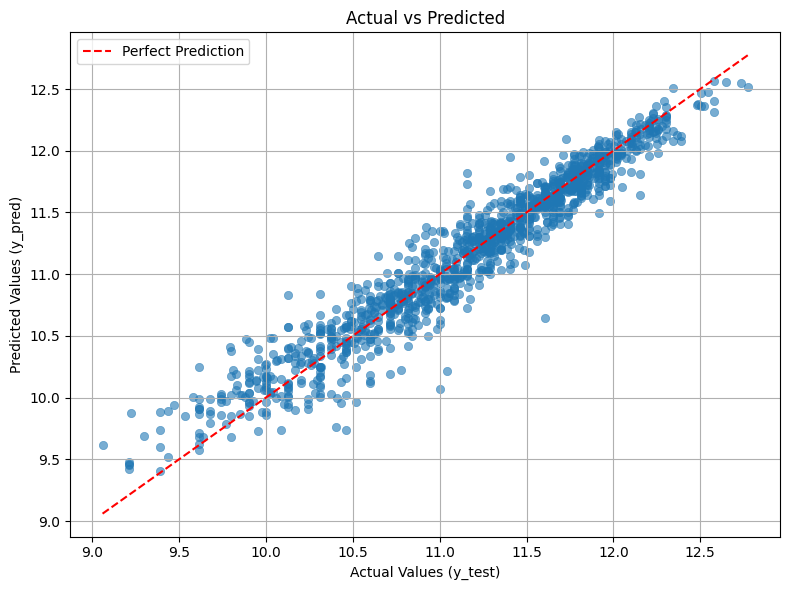

In [ ]:
y_test = y_test
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# function for preprocessing
from preprocessing_d import ML_scale_tranfsormed
def ml_preprocess(bikes):
    bikes1=preprocessing_d.BikePreprocess(bikes)
    bikes1=bikes1.preprocess_dataset()
    bikes_trans=ML_scale_tranfsormed(bikes1).transform_data_freq()
    return bikes_trans

In [ ]:
bi=pd.read_csv("bikes.csv")
ml_preprocess(bi)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25.0,2017,17000.0,1,331.0,35.0,19.0,63500,2091.0,220.0
1,69.0,2016,50000.0,1,331.0,35.0,19.0,115000,1744.0,350.0
2,6.0,2012,14795.0,1,331.0,30.0,28.0,300000,52.0,250.0
3,31.0,2017,28.0,1,6.0,28.0,34.0,100000,2091.0,400.0
4,8.0,2020,2000.0,1,757.0,30.0,30.0,197500,46.0,330.0
...,...,...,...,...,...,...,...,...,...,...
7852,9.0,2011,7000.0,1,24.0,42.0,16.0,55000,744.0,150.0
7853,2.0,2015,80.0,1,1401.0,80.0,7.7,28000,2091.0,100.0
7854,19.0,2016,6407.0,1,757.0,65.0,17.0,61740,2091.0,180.0
7855,52.0,2016,7524.0,1,757.0,57.0,11.0,49000,2091.0,150.0


In [ ]:
model.predict(ml_preprocess(bi).drop("price", axis=1))

array([11.23261711, 11.65897699, 11.72603658, ..., 10.95991058,
       10.78254523, 10.98577147], shape=(7826,))

In [ ]:
bi=ml_preprocess(bi)

In [ ]:
bi.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25.0,2017,17000.0,1,331.0,35.0,19.0,63500,2091.0,220.0
1,69.0,2016,50000.0,1,331.0,35.0,19.0,115000,1744.0,350.0
2,6.0,2012,14795.0,1,331.0,30.0,28.0,300000,52.0,250.0
3,31.0,2017,28.0,1,6.0,28.0,34.0,100000,2091.0,400.0
4,8.0,2020,2000.0,1,757.0,30.0,30.0,197500,46.0,330.0


In [ ]:
#bi[numerical_cols_x] = qt_normal_x.transform(bi[numerical_cols_x])

In [ ]:
y_bi=bi["price"]

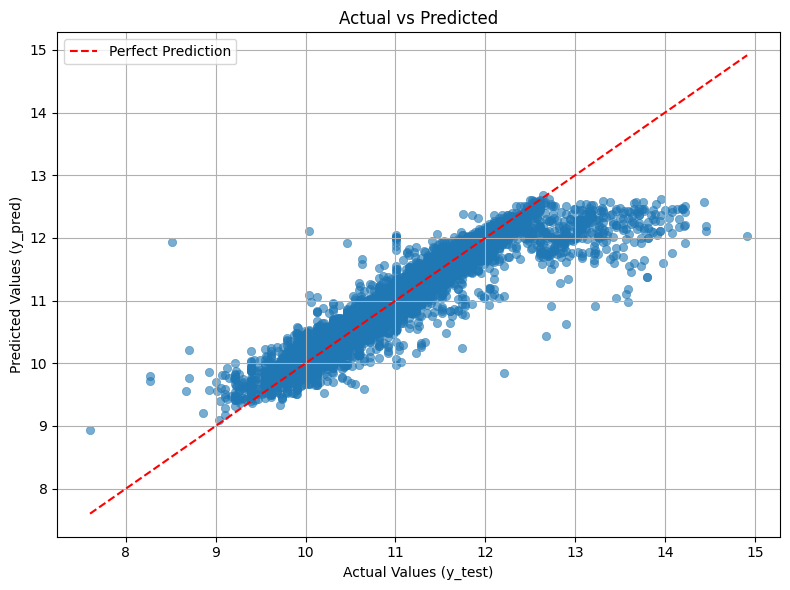

In [ ]:
y_test = np.log1p(y_bi)
y_pred = model.predict(bi.drop("price", axis=1))
#

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_test = np.log1p(y_bi)
y_pred = model.predict(bi.drop("price", axis=1))
#
# Suppose you already calculated RMSE
rmse = root_mean_squared_error(y_test, y_pred)

# Check price statistics in bikes1
mean_price = y_test.mean()
median_price = pd.DataFrame(y_train).median()
min_price = y_test.min()
max_price = y_test.max()

# Calculate relative error (as a percentage of mean price)
relative_error = (rmse / mean_price) * 100
print("R2 Score:", r2_score(y_test, y_pred))
# Print comparison
print(f"📌 RMSE: {rmse:}")
print(f"💰 Mean Price: {mean_price}")
print(f"📈 Median Price: {median_price}")
print(f"⬇️ Min Price: {min_price}")
print(f"⬆️ Max Price: {max_price}")
print(f"📊 RMSE as % of mean price: {relative_error:.2f}%")

# Optional quick judgement
if relative_error < 10:
    print("✅ Excellent RMSE (less than 10% of mean price)")
elif relative_error < 20:
    print("✅ Good RMSE (10–20% of mean price)")
elif relative_error < 30:
    print("⚠️ Acceptable RMSE (20–30% of mean price)")
else:
    print("❌ High RMSE (more than 30% of mean price) — could be improved")
print("Adjusted R-squared:", 1 - (1 - model.score(bi.drop("price", axis=1), y_test)) * (len(y_test) - 1) / (len(y_test) - bi.drop("price", axis=1).shape[1] - 1))

R2 Score: 0.8429307044272631
📌 RMSE: 0.3267947259256875
💰 Mean Price: 11.205537523008779
📈 Median Price: price    11.225257
dtype: float64
⬇️ Min Price: 7.601402334583733
⬆️ Max Price: 14.914123179965662
📊 RMSE as % of mean price: 2.92%
✅ Excellent RMSE (less than 10% of mean price)
Adjusted R-squared: 0.8427498416252986


In [ ]:
bi

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25.0,2017,17000.0,1,331.0,35.0,19.0,63500,2091.0,220.0
1,69.0,2016,50000.0,1,331.0,35.0,19.0,115000,1744.0,350.0
2,6.0,2012,14795.0,1,331.0,30.0,28.0,300000,52.0,250.0
3,31.0,2017,28.0,1,6.0,28.0,34.0,100000,2091.0,400.0
4,8.0,2020,2000.0,1,757.0,30.0,30.0,197500,46.0,330.0
...,...,...,...,...,...,...,...,...,...,...
7852,9.0,2011,7000.0,1,24.0,42.0,16.0,55000,744.0,150.0
7853,2.0,2015,80.0,1,1401.0,80.0,7.7,28000,2091.0,100.0
7854,19.0,2016,6407.0,1,757.0,65.0,17.0,61740,2091.0,180.0
7855,52.0,2016,7524.0,1,757.0,57.0,11.0,49000,2091.0,150.0


## Model with only Outliers

In [ ]:
final_cluster

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,25.0,2017.0,17000.0,1.0,331.0,35.000000,19.0,63500.0,2091.0,220.000000
1,69.0,2016.0,50000.0,1.0,331.0,35.000000,19.0,115000.0,1744.0,350.000000
3,31.0,2017.0,28.0,1.0,6.0,28.000000,34.0,100000.0,2091.0,400.000000
4,8.0,2020.0,2000.0,1.0,757.0,30.000000,30.0,197500.0,46.0,330.000000
6,19.0,2016.0,19718.0,1.0,757.0,65.000000,17.0,55000.0,2091.0,180.000000
...,...,...,...,...,...,...,...,...,...,...
7850,3.0,2018.0,16510.0,1.0,230.0,51.321739,16.0,60000.0,561.0,160.000000
7851,21.0,2015.0,35.0,1.0,1.0,35.000000,24.0,80000.0,2091.0,183.773522
7852,9.0,2011.0,7000.0,1.0,24.0,42.000000,16.0,55000.0,744.0,150.000000
7854,19.0,2016.0,6407.0,1.0,757.0,65.000000,17.0,61740.0,2091.0,180.000000


In [ ]:
final_cluster_outlier=bikes_HDBSCAN[bikes_HDBSCAN["Cluster"]==-1][bikes_trans.columns]

In [ ]:
final_cluster_outlier

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
2,-0.561629,-0.873856,-0.025353,-0.344359,-0.345099,-1.000815,1.337245,3.918678,-1.713963,0.219589
5,-0.621604,-0.873856,0.570960,4.041911,0.503709,-0.668117,0.927886,-0.397554,-1.096749,-0.237709
15,-0.021852,0.653909,-0.926172,4.041911,1.786884,-0.202340,0.654980,-0.587278,1.152777,-0.386116
16,1.417552,0.908536,-0.157304,-0.344359,1.786884,-0.668117,0.109168,1.364694,0.664911,1.134184
23,0.877776,0.144654,-0.345552,-0.344359,1.786884,0.529596,0.109168,-0.605521,1.152777,-0.054790
...,...,...,...,...,...,...,...,...,...,...
7837,-0.681579,-1.637738,0.597766,-0.344359,1.786884,0.328603,-1.173490,-1.152803,1.152777,-0.832196
7842,-0.741554,-1.383110,-0.922387,-0.344359,1.786884,-2.331608,-1.364524,-1.284151,1.152777,-1.152304
7844,-0.741554,-2.910874,-0.623498,-0.344359,-0.394912,-0.002721,-1.651075,-1.244017,-0.677775,-1.152304
7853,-0.801529,-0.109973,-0.923852,-0.344359,1.786884,2.326166,-1.432750,-1.043347,1.152777,-1.152304


In [ ]:
final_cluster_outlier.shape

(985, 10)

In [ ]:
final_cluster_outlier

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
2,-0.561629,-0.873856,-0.025353,-0.344359,-0.345099,-1.000815,1.337245,3.918678,-1.713963,0.219589
5,-0.621604,-0.873856,0.570960,4.041911,0.503709,-0.668117,0.927886,-0.397554,-1.096749,-0.237709
15,-0.021852,0.653909,-0.926172,4.041911,1.786884,-0.202340,0.654980,-0.587278,1.152777,-0.386116
16,1.417552,0.908536,-0.157304,-0.344359,1.786884,-0.668117,0.109168,1.364694,0.664911,1.134184
23,0.877776,0.144654,-0.345552,-0.344359,1.786884,0.529596,0.109168,-0.605521,1.152777,-0.054790
...,...,...,...,...,...,...,...,...,...,...
7837,-0.681579,-1.637738,0.597766,-0.344359,1.786884,0.328603,-1.173490,-1.152803,1.152777,-0.832196
7842,-0.741554,-1.383110,-0.922387,-0.344359,1.786884,-2.331608,-1.364524,-1.284151,1.152777,-1.152304
7844,-0.741554,-2.910874,-0.623498,-0.344359,-0.394912,-0.002721,-1.651075,-1.244017,-0.677775,-1.152304
7853,-0.801529,-0.109973,-0.923852,-0.344359,1.786884,2.326166,-1.432750,-1.043347,1.152777,-1.152304


In [ ]:
df_outliers

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc,anomaly
76,10,2011,67000.0,1,1401,5.000000,8.2,26000,789,100.0,-1
77,10,2011,56194.0,1,1401,5.000000,8.2,20000,789,100.0,-1
259,7,2019,95000.0,2,1401,51.321739,16.0,55000,561,160.0,-1
263,7,2019,95000.0,2,802,51.321739,16.0,61000,561,160.0,-1
272,5,2006,125000.0,1,7,89.000000,8.1,9900,2091,100.0,-1
...,...,...,...,...,...,...,...,...,...,...,...
7738,2,2004,99890.0,1,10,65.000000,12.0,14900,2091,125.0,-1
7739,2,2004,99999.0,1,10,65.000000,12.0,13900,2091,125.0,-1
7805,7,2013,113000.0,1,336,65.000000,14.0,33000,789,150.0,-1
7823,3,2012,92466.0,1,306,85.000000,8.2,18000,561,110.0,-1


In [ ]:
df_outliers.drop("anomaly", axis=1, inplace=True)

In [ ]:
final_cluster_outlier

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
2,-0.561629,-0.873856,-0.025353,-0.344359,-0.345099,-1.000815,1.337245,3.918678,-1.713963,0.219589
5,-0.621604,-0.873856,0.570960,4.041911,0.503709,-0.668117,0.927886,-0.397554,-1.096749,-0.237709
15,-0.021852,0.653909,-0.926172,4.041911,1.786884,-0.202340,0.654980,-0.587278,1.152777,-0.386116
16,1.417552,0.908536,-0.157304,-0.344359,1.786884,-0.668117,0.109168,1.364694,0.664911,1.134184
23,0.877776,0.144654,-0.345552,-0.344359,1.786884,0.529596,0.109168,-0.605521,1.152777,-0.054790
...,...,...,...,...,...,...,...,...,...,...
7837,-0.681579,-1.637738,0.597766,-0.344359,1.786884,0.328603,-1.173490,-1.152803,1.152777,-0.832196
7842,-0.741554,-1.383110,-0.922387,-0.344359,1.786884,-2.331608,-1.364524,-1.284151,1.152777,-1.152304
7844,-0.741554,-2.910874,-0.623498,-0.344359,-0.394912,-0.002721,-1.651075,-1.244017,-0.677775,-1.152304
7853,-0.801529,-0.109973,-0.923852,-0.344359,1.786884,2.326166,-1.432750,-1.043347,1.152777,-1.152304


In [ ]:

final_cluster_outlier=pd.DataFrame(scaler_cluster.inverse_transform(final_cluster_outlier), columns=final_cluster_outlier.columns, index=final_cluster_outlier.index)

In [ ]:
final_cluster_outlier_ap=pd.concat([final_cluster_outlier, df_outliers])

In [ ]:
final_cluster_outlier_ap.shape

(1367, 10)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
X=final_cluster_outlier_ap.drop("price", axis=1)
y=final_cluster_outlier_ap["price"]
# log transformation
y=np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
"""X_train[numerical_cols_x] = qt_normal_x.transform(X_train[numerical_cols_x])
X_test[numerical_cols_x] = qt_normal_x.transform(X_test[numerical_cols_x])"""

'X_train[numerical_cols_x] = qt_normal_x.transform(X_train[numerical_cols_x])\nX_test[numerical_cols_x] = qt_normal_x.transform(X_test[numerical_cols_x])'

In [ ]:
X_test

,model_name,model_year,kms_driven,owner,location,mileage,power,brand,cc
3088,7.0,1982.0,10000.0,1.0,802.0,34.333537,21.392652,1744.0,350.000000
2301,4.0,2010.0,90000.0,1.0,2.0,65.000000,14.000000,789.0,150.000000
5133,2.0,2021.0,100.0,1.0,230.0,56.576000,30.000000,522.0,141.062338
4192,4.0,2012.0,80.0,1.0,1.0,80.000000,7.700000,2091.0,100.000000
847,19.0,2018.0,54000.0,2.0,1401.0,49.979355,15.000000,2091.0,183.773522
...,...,...,...,...,...,...,...,...,...
2638,1.0,1978.0,85000.0,1.0,1.0,30.000000,20.520101,1.0,250.000000
6107,2.0,2009.0,80.0,1.0,1401.0,80.000000,7.700000,2091.0,100.000000
3468,27.0,2014.0,16000.0,1.0,1401.0,25.000000,27.000000,1744.0,500.000000
4627,7.0,2011.0,65.0,3.0,802.0,65.000000,10.000000,522.0,125.000000


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define the base model
cat_model_outlier = CatBoostRegressor(random_seed=42, verbose=False)

# Define the hyperparameter grid
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model_outlier,
    param_grid=param_grid,
    scoring='r2',        # or use 'neg_root_mean_squared_error'
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
model_outlier=grid_search.best_estimator_

# ===== 6. Evaluate =====
y_pred = model_outlier.predict(X_test)
# Suppose you already calculated RMSE
rmse = root_mean_squared_error(y_test, y_pred)

# Check price statistics in bikes1
mean_price = y_train.mean()
median_price = pd.DataFrame(y_train).median()
min_price = y_train.min()
max_price = y_train.max()

# Calculate relative error (as a percentage of mean price)
relative_error = (rmse / mean_price) * 100
print("R2 Score:", r2_score(y_test, y_pred))
# Print comparison
print(f"📌 RMSE: {rmse:}")
print(f"💰 Mean Price: {mean_price}")
print(f"📈 Median Price: {median_price}")
print(f"⬇️ Min Price: {min_price}")
print(f"⬆️ Max Price: {max_price}")
print(f"📊 RMSE as % of mean price: {relative_error:.2f}%")

# Optional quick judgement
if relative_error < 10:
    print("✅ Excellent RMSE (less than 10% of mean price)")
elif relative_error < 20:
    print("✅ Good RMSE (10–20% of mean price)")
elif relative_error < 30:
    print("⚠️ Acceptable RMSE (20–30% of mean price)")
else:
    print("❌ High RMSE (more than 30% of mean price) — could be improved")
print("Adjusted R-squared:", 1 - (1 - model.score(X_test, y_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

Best Parameters: {'depth': 6, 'iterations': 500, 'learning_rate': 0.05}
R2 Score: 0.8873651901474696
📌 RMSE: 0.34183877374840765
💰 Mean Price: 11.105170325655445
📈 Median Price: price    11.002117
dtype: float64
⬇️ Min Price: 8.268988209506656
⬆️ Max Price: 13.116347317149176
📊 RMSE as % of mean price: 3.08%
✅ Excellent RMSE (less than 10% of mean price)
Adjusted R-squared: 0.777618132274358


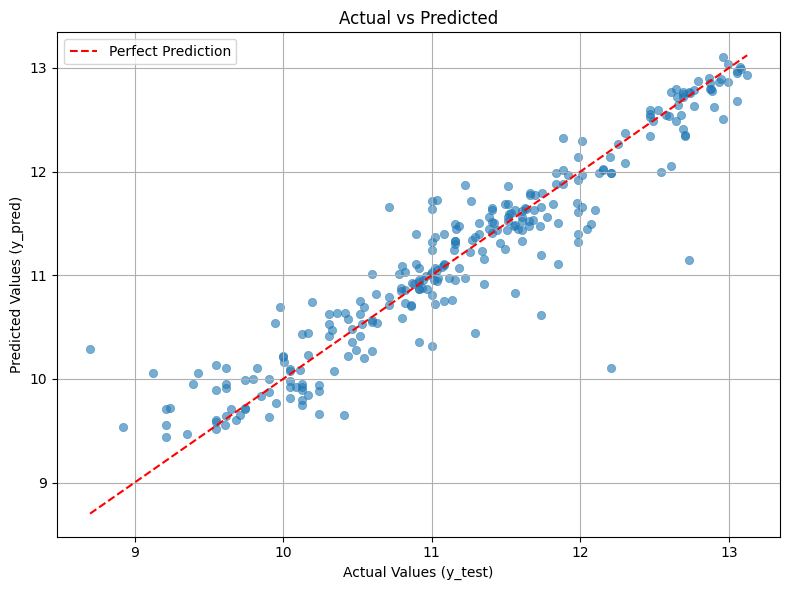

In [ ]:
y_test = y_test
y_pred = model_outlier.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Models Saving

In [ ]:
# Separating data between outliers and non-outliers saving StandardScaler and HDBSCAN for same purpose
import os
import pickle

# Ensure folder exists
os.makedirs("saved_models", exist_ok=True)


# saving Cluster model
with open(f"saved_models/Cluster_predictor.pkl", "wb") as f:
    pickle.dump(rf_cluster, f)


# Catboost model for outlier
with open(f"saved_models/Catboost_model_outlier.pkl", "wb") as f:
    pickle.dump(model_outlier, f)


# Saving Catboost model for without outlier
with open(f"saved_models/Catboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
X=bikes_HDBSCAN_n.drop("Cluster", axis=1)
y=bikes_HDBSCAN_n["Cluster"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_cluster.score(X_test, y_test)


0.9469331495520331

In [ ]:
bikes_HDBSCAN_n

,model_name,model_year,kms_driven,owner,location,mileage,power,brand,cc,Cluster
0,25.0,2017.0,17000.0,1.0,331.0,35.0,19.0,2091.0,220.0,18
1,69.0,2016.0,50000.0,1.0,331.0,35.0,19.0,1744.0,350.0,13
2,6.0,2012.0,14795.0,1.0,331.0,30.0,28.0,52.0,250.0,-1
3,31.0,2017.0,28.0,1.0,6.0,28.0,34.0,2091.0,400.0,11
4,8.0,2020.0,2000.0,1.0,757.0,30.0,30.0,46.0,330.0,8
...,...,...,...,...,...,...,...,...,...,...
7852,9.0,2011.0,7000.0,1.0,24.0,42.0,16.0,744.0,150.0,8
7853,2.0,2015.0,80.0,1.0,1401.0,80.0,7.7,2091.0,100.0,-1
7854,19.0,2016.0,6407.0,1.0,757.0,65.0,17.0,2091.0,180.0,18
7855,52.0,2016.0,7524.0,1.0,757.0,57.0,11.0,2091.0,150.0,-1
